# Data collection

In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import os
from PIL import Image 
import PIL

In [ ]:
if input("Are you using Google Colab? y/n") in ['y','Y']:
    from google.colab import auth
    auth.authenticate_user()
    from googleapiclient.discovery import build
    drive_service = build('drive', 'v3')
    from google.colab import drive
    drive.mount('/content/drive')
    input_art_dir='/content/drive/My Drive/Data/monet/monet_jpg'
    target_photo_dir='/content/drive/My Drive/Data/monet/photo_jpg'
else:
    input_art_dir='/Users/bryton/Desktop/Data/monet/monet_jpg'
    target_photo_dir='/Users/bryton/Desktop/Data/monet/photo_jpg'

input_art_paths = sorted(
    [os.path.join(input_art_dir, fname)
     for fname in os.listdir(input_art_dir)
     if fname.endswith(".jpg")])
input_photo_paths = sorted(
    [os.path.join(target_photo_dir, fname)
     for fname in os.listdir(target_photo_dir)
     if fname.endswith(".jpg")])

Are you using Google Colab? y/ny
Mounted at /content/drive


In [2]:
if input("Are you using Google Colab? y/n") in ['y','Y']:
    from google.colab import auth
    auth.authenticate_user()
    from googleapiclient.discovery import build
    drive_service = build('drive', 'v3')
    from google.colab import drive
    drive.mount('/content/drive')
    input_art_dir='/content/drive/My Drive/Data/monet/monet_jpg'
    target_photo_dir='/content/drive/My Drive/Data/photo.jpg'
else:
    input_art_dir='/Users/bryton/Desktop/Data/monet/monet_jpg'
    target_photo_dir='/Users/bryton/Desktop/Data/monet/photo_jpg'

input_art_paths = sorted(
    [os.path.join(input_art_dir, fname)
     for fname in os.listdir(input_art_dir)
     if fname.endswith(".jpg")])
# input_photo_paths = sorted(
#     [os.path.join(target_photo_dir, fname)
#      for fname in os.listdir(target_photo_dir)
#      if fname.endswith(".jpg")])

Are you using Google Colab? y/ny
Mounted at /content/drive


# Data preprocessing

In [ ]:
img_size = (256, 256)
num_art = len(input_art_paths)
num_photo = len(input_photo_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path))

input_art = np.zeros((num_art,) + img_size + (3,), dtype="float32")
input_photo = np.zeros((num_photo,) + img_size + (3,), dtype="float32")

for i in range(num_art):
    input_art[i] = path_to_input_image(input_art_paths[i])
for i in range(num_photo):
    input_photo[i] = path_to_input_image(input_photo_paths[i])

KeyboardInterrupt: ignored

In [ ]:
def display_samples(ds, row, col):
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        example_sample = ds[j]
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(array_to_img(example_sample))
    plt.show()

# Take a look on the picture

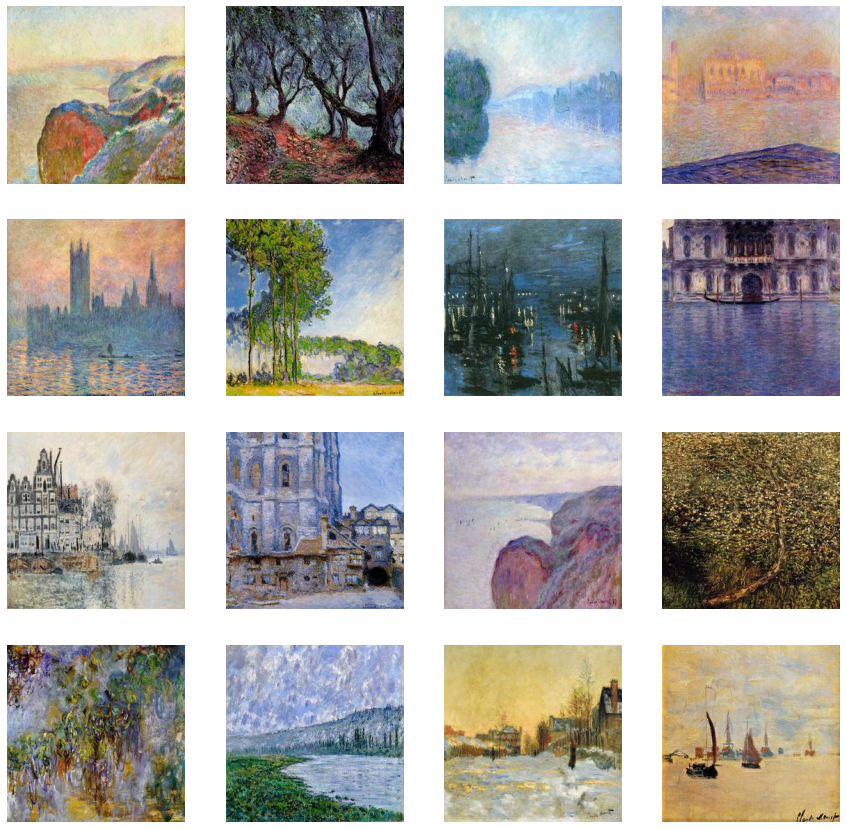

In [ ]:
display_samples(input_art, 4, 4)

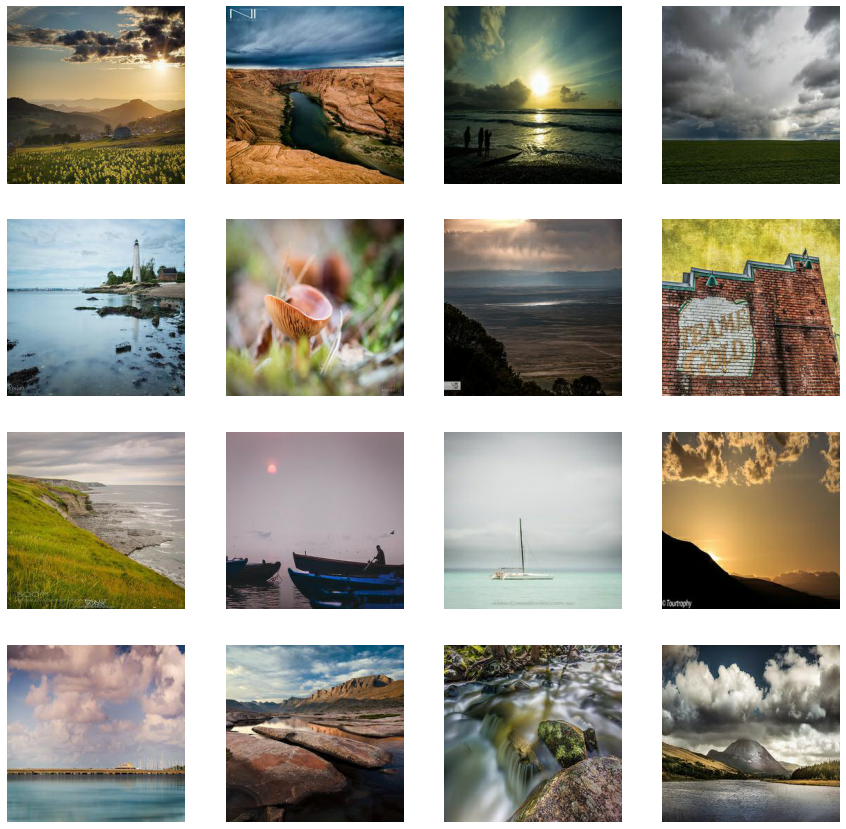

In [ ]:
display_samples(input_photo, 4, 4)

# Neural Style Transfer

In [3]:
import platform

print(f"Python version: {platform.python_version()}")

from IPython.display import Image, display

import numpy as np
import tensorflow as tf
import random

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

from tensorflow.keras import Model
from tensorflow.keras.applications import vgg19
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

Python version: 3.7.13
TensorFlow version: 2.8.0
Keras version: 2.8.0


In [7]:
rand_photo = random.randint(0, 7038)
rand_art = random.randint(0, 300)

# Get content and style images
base_image_path = target_photo_dir
style_reference_image_path = style_art_path = input_art_paths[rand_art]


width, height = load_img(base_image_path).size
print(f"Input image dimensions: {width, height}")

Input image dimensions: (4032, 2268)


In [8]:
# Show content images
display(Image(base_image_path))

Output hidden; open in https://colab.research.google.com to view.

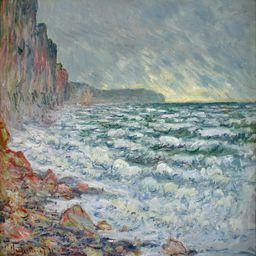

In [9]:
# Show style reference image
display(Image(style_reference_image_path))

In [10]:
def preprocess_image(image_path, height, width):
    """Open, resize and format a picture into appropriate tensors"""
    img = load_img(
        image_path, target_size=(height, width)
    )
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # Convert image from RGB to BGR and zero-center each color channel w.r.t. the ImageNet dataset
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x, height, width):
    """Convert a tensor into a valid image"""
    x = x.reshape((height, width, 3))
    # Remove zero-center by mean pixel applied by vgg19.preprocess_input()
    # The following values are the mean pixel values of each color channel for the ImageNet dataset
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [11]:
# The gram matrix of a 3D tensor (correlations between the feature maps of a convolutional layer)
def gram_matrix(x):
    # Transpose feature maps tensor tensor so that 3rd dimension becomes 1st
    x = tf.transpose(x, (2, 0, 1))
    # Reshape feature maps tensor into a matrix. First dimension is the number of filters/maps 
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    # Compute the outer product of feature vectors with themselves
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The style loss is designed to maintain the style of the reference image in the generated image
# It is based on the gram matrices (which capture style) of feature maps from the style reference image
# and from the generated image
def style_loss(style, combination, height, width):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    # Compute distance between Gram matrices of style and generated images
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [12]:
# The content loss is designed to maintain the "content" of the base image in the generated image
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

# The total variation loss is designed to keep the generated image locally coherent
def total_variation_loss(x, height, width):
    a = tf.square(
        x[:, : height - 1, : width - 1, :] - x[:, 1:, : width - 1, :]
    )
    b = tf.square(
        x[:, : height - 1, : width - 1, :] - x[:, : height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [13]:
# Using the convolutional base of VGG19, loaded with pre-trained ImageNet weights
vgg = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names)
outputs_dict = dict([(layer.name, layer.output) for layer in vgg.layers])

# Set up a model that returns the activation values for every layer in VGG19 (as a dict)
feature_extractor = Model(inputs=vgg.inputs, outputs=outputs_dict)

80150528/80134624 [==============================] - 0s 0us/step


In [14]:
# List of layers to use for the style loss
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss
content_layer_name = "block5_conv2"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image, height, width):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features, height, width)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image, height, width)
    return loss

In [15]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image, height, width):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image, height, width)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [16]:
# Generated image height
gen_height = 256
# Compute generated width so that input and generated images have same scale
gen_width = int(width * gen_height / height)
print(f"Generated image dimensions: {gen_width, gen_height}")

Generated image dimensions: (455, 256)


In [17]:
# optimizer = SGD(
#     ExponentialDecay(
#         initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
#     )
# )

optimizer = Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

base_image = preprocess_image(base_image_path, gen_height, gen_width)
style_reference_image = preprocess_image(style_reference_image_path, gen_height, gen_width)
combination_image = tf.Variable(preprocess_image(base_image_path, gen_height, gen_width))

# Training loop
n_epochs = 4000
for epoch in range(1, n_epochs + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image, gen_height, gen_width
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{n_epochs}], loss: {loss:.2f}")

# Save final image
final_img = deprocess_image(combination_image.numpy(), gen_height, gen_width)
result_image_path = f"generated_image_epoch_{n_epochs}.png"
save_img(result_image_path, final_img)

Epoch [100/4000], loss: 67464.33
Epoch [200/4000], loss: 56548.34
Epoch [300/4000], loss: 47490.27
Epoch [400/4000], loss: 40509.85
Epoch [500/4000], loss: 35190.22
Epoch [600/4000], loss: 31117.99
Epoch [700/4000], loss: 27944.43
Epoch [800/4000], loss: 25418.58
Epoch [900/4000], loss: 23360.23
Epoch [1000/4000], loss: 21653.87
Epoch [1100/4000], loss: 20215.26
Epoch [1200/4000], loss: 18983.29
Epoch [1300/4000], loss: 17915.64
Epoch [1400/4000], loss: 16980.09
Epoch [1500/4000], loss: 16152.36
Epoch [1600/4000], loss: 15414.18
Epoch [1700/4000], loss: 14752.33
Epoch [1800/4000], loss: 14154.59
Epoch [1900/4000], loss: 13610.89
Epoch [2000/4000], loss: 13114.21
Epoch [2100/4000], loss: 12657.84
Epoch [2200/4000], loss: 12236.63
Epoch [2300/4000], loss: 11846.78
Epoch [2400/4000], loss: 11485.25
Epoch [2500/4000], loss: 11149.01
Epoch [2600/4000], loss: 10835.03
Epoch [2700/4000], loss: 10541.07
Epoch [2800/4000], loss: 10264.91
Epoch [2900/4000], loss: 10005.22
Epoch [3000/4000], loss

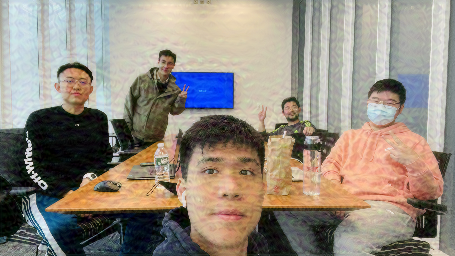

In [18]:
# Show final generated image
display(Image(result_image_path))